In [1]:
import sys
if 'google.colab' in sys.modules:
# Add the directory containing your module to the Python path
  from google.colab import drive
  drive.mount('/content/drive')
  module_path = '/content/drive/MyDrive/Colab_Notebooks/Session9'
  sys.path.append(module_path)
  print(sys.path)

Mounted at /content/drive
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab_Notebooks/Session9']


## Import Modules


In [2]:
# Import necessary library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import math
from collections import OrderedDict

In [3]:
!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Dataset Analysis

## Extract and Load the Data

In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 94333547.89it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Data Statistics

[Train]
 - Total Train Images: 50000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49139968, 0.48215827, 0.44653124)
 - std: (0.24703233, 0.24348505, 0.26158768)
 - var: (0.061024975, 0.05928497, 0.06842812)
[Test]
 - Total Test Images: 10000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49421427, 0.48513183, 0.45040932)
 - std: (0.24665256, 0.24289224, 0.26159248)
 - var: (0.06083748, 0.058996636, 0.06843062)


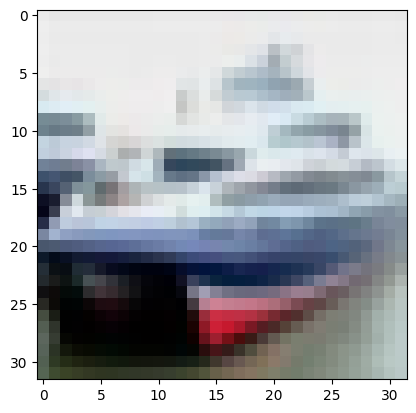

In [5]:
from utils import get_cifar_statistics

get_cifar_statistics(train)
get_cifar_statistics(test, data_set_type="Test")

## Parameters

In [6]:
BATCH_SIZE = 512
EPOCHS = 100
DISPLAY_SAMPLES = 20
LEARNING_RATE = 0.112
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
MAX_LR = 0.1

## Visualize Training Data

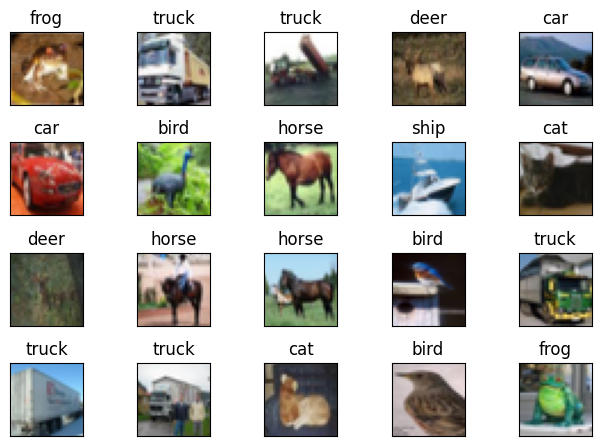

In [7]:
from utils import display_cifar_data_samples

sample, _ = train[4]
display_cifar_data_samples(train, DISPLAY_SAMPLES, classes)

## Transformations

In [8]:
# Train Phase transformations
train_set_transforms = {
    'horizontalflip': A.HorizontalFlip(),
    'shiftscalerotate': A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

# Test Phase transformations
test_set_transforms = {
    'normalize': A.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2()
}

train_transforms = A.Compose(train_set_transforms.values())
test_transforms = A.Compose(test_set_transforms.values())

## Get Transformed Dataset

In [9]:
from datasets import TransformedDataset

train_set = TransformedDataset('./data', train=True, download=True, transform=train_transforms)
test_set = TransformedDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Visualize Augmentations

Files already downloaded and verified


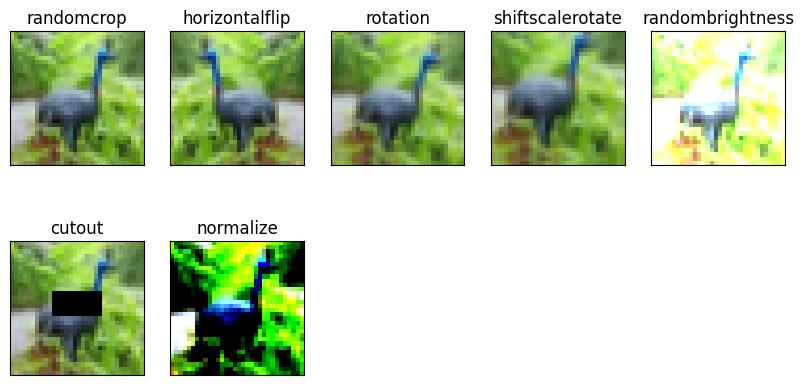

In [10]:
from utils import visualize_cifar_augmentation

aug_train = TransformedDataset('./data', train=True, download=True)

aug_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=1),
    'horizontalflip': A.HorizontalFlip(p=1),
    'rotation': A.Rotate(15, p=1),
    'shiftscalerotate': A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=1),
    'randombrightness': A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None, p=1),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

visualize_cifar_augmentation(aug_train, aug_set_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [11]:
SEED = 48

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


In [12]:
STEPS_PER_EPOCH =int(len(train_loader)*1)
print(f'STEPS_PER_EPOCH {STEPS_PER_EPOCH}')

STEPS_PER_EPOCH 98


In [13]:
len(train_loader)

98

## Model and its Parameters

In [14]:
from models import Session9Net, get_summary
get_summary(Session9Net(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 15, 15]           9,216
       BatchNorm2d-8           [-1, 32, 15, 15]              64
              ReLU-9           [-1, 32, 15, 15]               0
           Conv2d-10           [-1, 38, 15, 15]          10,944
      BatchNorm2d-11           [-1, 38, 15, 15]              76
             ReLU-12           [-1, 38, 15, 15]               0
           Conv2d-13           [-1, 38, 15, 15]          12,996
      BatchNorm2d-14           [-1, 38,

## Model Training and Testing

In [15]:
from training_utils import train, test

In [16]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [17]:


# Put the model on selected device
model = Session9Net().to(device)

# Optimization algorithm to update the weights
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Scheduler to change the learning rate after specific number of epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)

# New Line
criterion = F.nll_loss

# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.8411 Batch_id=97 Accuracy=22.31: 100%|██████████| 98/98 [00:09<00:00, 10.34it/s]


Test set: Average loss: 1.7889, Accuracy: 3303/10000 (33.03%)

Epoch 2


Train: Loss=1.5272 Batch_id=97 Accuracy=37.70: 100%|██████████| 98/98 [00:08<00:00, 11.25it/s]


Test set: Average loss: 1.5088, Accuracy: 4390/10000 (43.90%)

Epoch 3


Train: Loss=1.3502 Batch_id=97 Accuracy=46.09: 100%|██████████| 98/98 [00:09<00:00,  9.97it/s]


Test set: Average loss: 1.3560, Accuracy: 5006/10000 (50.06%)

Epoch 4


Train: Loss=1.2708 Batch_id=97 Accuracy=50.72: 100%|██████████| 98/98 [00:10<00:00,  8.91it/s]


Test set: Average loss: 1.2204, Accuracy: 5587/10000 (55.87%)

Epoch 5


Train: Loss=1.1516 Batch_id=97 Accuracy=55.01: 100%|██████████| 98/98 [00:10<00:00,  9.79it/s]


Test set: Average loss: 1.1493, Accuracy: 5846/10000 (58.46%)

Epoch 6


Train: Loss=1.2218 Batch_id=97 Accuracy=58.70: 100%|██████████| 98/98 [00:09<00:00, 10.24it/s]


Test set: Average loss: 1.2725, Accuracy: 5606/10000 (56.06%)

Epoch 7


Train: Loss=0.9320 Batch_id=97 Accuracy=61.57: 100%|██████████| 98/98 [00:10<00:00,  9.42it/s]


Test set: Average loss: 1.0386, Accuracy: 6334/10000 (63.34%)

Epoch 8


Train: Loss=1.0131 Batch_id=97 Accuracy=63.50: 100%|██████████| 98/98 [00:10<00:00,  9.08it/s]


Test set: Average loss: 0.9393, Accuracy: 6706/10000 (67.06%)

Epoch 9


Train: Loss=0.9250 Batch_id=97 Accuracy=65.21: 100%|██████████| 98/98 [00:09<00:00,  9.82it/s]


Test set: Average loss: 0.8798, Accuracy: 6898/10000 (68.98%)

Epoch 10


Train: Loss=0.9259 Batch_id=97 Accuracy=67.73: 100%|██████████| 98/98 [00:08<00:00, 10.94it/s]


Test set: Average loss: 0.8328, Accuracy: 7101/10000 (71.01%)

Epoch 11


Train: Loss=0.8714 Batch_id=97 Accuracy=68.83: 100%|██████████| 98/98 [00:10<00:00,  9.77it/s]


Test set: Average loss: 0.9613, Accuracy: 6787/10000 (67.87%)

Epoch 12


Train: Loss=0.8657 Batch_id=97 Accuracy=70.30: 100%|██████████| 98/98 [00:10<00:00,  9.54it/s]


Test set: Average loss: 0.8363, Accuracy: 7155/10000 (71.55%)

Epoch 13


Train: Loss=0.6936 Batch_id=97 Accuracy=71.43: 100%|██████████| 98/98 [00:10<00:00,  9.63it/s]


Test set: Average loss: 0.7680, Accuracy: 7377/10000 (73.77%)

Epoch 14


Train: Loss=0.7402 Batch_id=97 Accuracy=72.45: 100%|██████████| 98/98 [00:08<00:00, 11.24it/s]


Test set: Average loss: 0.7542, Accuracy: 7408/10000 (74.08%)

Epoch 15


Train: Loss=0.7509 Batch_id=97 Accuracy=73.31: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]


Test set: Average loss: 0.7527, Accuracy: 7417/10000 (74.17%)

Epoch 16


Train: Loss=0.7315 Batch_id=97 Accuracy=74.14: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s]


Test set: Average loss: 0.8312, Accuracy: 7158/10000 (71.58%)

Epoch 17


Train: Loss=0.7277 Batch_id=97 Accuracy=74.44: 100%|██████████| 98/98 [00:10<00:00,  9.48it/s]


Test set: Average loss: 0.8319, Accuracy: 7260/10000 (72.60%)

Epoch 18


Train: Loss=0.7517 Batch_id=97 Accuracy=75.28: 100%|██████████| 98/98 [00:08<00:00, 10.92it/s]


Test set: Average loss: 0.6922, Accuracy: 7643/10000 (76.43%)

Epoch 19


Train: Loss=0.7242 Batch_id=97 Accuracy=75.48: 100%|██████████| 98/98 [00:09<00:00, 10.55it/s]


Test set: Average loss: 0.7627, Accuracy: 7363/10000 (73.63%)

Epoch 20


Train: Loss=0.6403 Batch_id=97 Accuracy=76.35: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s]


Test set: Average loss: 0.6997, Accuracy: 7655/10000 (76.55%)

Epoch 21


Train: Loss=0.7643 Batch_id=97 Accuracy=77.02: 100%|██████████| 98/98 [00:10<00:00,  9.48it/s]


Test set: Average loss: 0.6521, Accuracy: 7787/10000 (77.87%)

Epoch 22


Train: Loss=0.7389 Batch_id=97 Accuracy=77.40: 100%|██████████| 98/98 [00:10<00:00,  9.77it/s]


Test set: Average loss: 0.7077, Accuracy: 7578/10000 (75.78%)

Epoch 23


Train: Loss=0.6542 Batch_id=97 Accuracy=77.85: 100%|██████████| 98/98 [00:09<00:00, 10.66it/s]


Test set: Average loss: 0.7202, Accuracy: 7621/10000 (76.21%)

Epoch 24


Train: Loss=0.6245 Batch_id=97 Accuracy=78.17: 100%|██████████| 98/98 [00:09<00:00, 10.05it/s]


Test set: Average loss: 0.6349, Accuracy: 7786/10000 (77.86%)

Epoch 25


Train: Loss=0.6188 Batch_id=97 Accuracy=78.10: 100%|██████████| 98/98 [00:10<00:00,  9.60it/s]


Test set: Average loss: 0.8377, Accuracy: 7358/10000 (73.58%)

Epoch 26


Train: Loss=0.6359 Batch_id=97 Accuracy=78.91: 100%|██████████| 98/98 [00:10<00:00,  9.51it/s]


Test set: Average loss: 0.6122, Accuracy: 7925/10000 (79.25%)

Epoch 27


Train: Loss=0.6195 Batch_id=97 Accuracy=79.10: 100%|██████████| 98/98 [00:09<00:00, 10.41it/s]


Test set: Average loss: 0.5995, Accuracy: 7965/10000 (79.65%)

Epoch 28


Train: Loss=0.5838 Batch_id=97 Accuracy=79.29: 100%|██████████| 98/98 [00:09<00:00, 10.74it/s]


Test set: Average loss: 0.5877, Accuracy: 7978/10000 (79.78%)

Epoch 29


Train: Loss=0.5852 Batch_id=97 Accuracy=79.72: 100%|██████████| 98/98 [00:10<00:00,  9.19it/s]


Test set: Average loss: 0.6404, Accuracy: 7887/10000 (78.87%)

Epoch 30


Train: Loss=0.5674 Batch_id=97 Accuracy=80.04: 100%|██████████| 98/98 [00:10<00:00,  9.24it/s]


Test set: Average loss: 0.5626, Accuracy: 8077/10000 (80.77%)

Epoch 31


Train: Loss=0.5099 Batch_id=97 Accuracy=80.28: 100%|██████████| 98/98 [00:09<00:00,  9.85it/s]


Test set: Average loss: 0.6631, Accuracy: 7762/10000 (77.62%)

Epoch 32


Train: Loss=0.5184 Batch_id=97 Accuracy=80.38: 100%|██████████| 98/98 [00:09<00:00, 10.66it/s]


Test set: Average loss: 0.5601, Accuracy: 8091/10000 (80.91%)

Epoch 33


Train: Loss=0.6230 Batch_id=97 Accuracy=80.94: 100%|██████████| 98/98 [00:10<00:00,  9.58it/s]


Test set: Average loss: 0.5992, Accuracy: 8005/10000 (80.05%)

Epoch 34


Train: Loss=0.4386 Batch_id=97 Accuracy=80.93: 100%|██████████| 98/98 [00:10<00:00,  9.10it/s]


Test set: Average loss: 0.6371, Accuracy: 7927/10000 (79.27%)

Epoch 35


Train: Loss=0.6606 Batch_id=97 Accuracy=80.76: 100%|██████████| 98/98 [00:10<00:00,  9.69it/s]


Test set: Average loss: 0.6179, Accuracy: 7907/10000 (79.07%)

Epoch 36


Train: Loss=0.5581 Batch_id=97 Accuracy=81.24: 100%|██████████| 98/98 [00:09<00:00,  9.97it/s]


Test set: Average loss: 0.5724, Accuracy: 8082/10000 (80.82%)

Epoch 37


Train: Loss=0.5031 Batch_id=97 Accuracy=81.29: 100%|██████████| 98/98 [00:09<00:00, 10.07it/s]


Test set: Average loss: 0.5238, Accuracy: 8236/10000 (82.36%)

Epoch 38


Train: Loss=0.5866 Batch_id=97 Accuracy=82.15: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s]


Test set: Average loss: 0.5464, Accuracy: 8160/10000 (81.60%)

Epoch 39


Train: Loss=0.5084 Batch_id=97 Accuracy=81.88: 100%|██████████| 98/98 [00:10<00:00,  9.66it/s]


Test set: Average loss: 0.7143, Accuracy: 7695/10000 (76.95%)

Epoch 40


Train: Loss=0.5830 Batch_id=97 Accuracy=81.80: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s]


Test set: Average loss: 0.5786, Accuracy: 8077/10000 (80.77%)

Epoch 41


Train: Loss=0.4488 Batch_id=97 Accuracy=82.27: 100%|██████████| 98/98 [00:09<00:00,  9.88it/s]


Test set: Average loss: 0.5496, Accuracy: 8156/10000 (81.56%)

Epoch 42


Train: Loss=0.5035 Batch_id=97 Accuracy=82.41: 100%|██████████| 98/98 [00:09<00:00,  9.92it/s]


Test set: Average loss: 0.5421, Accuracy: 8173/10000 (81.73%)

Epoch 43


Train: Loss=0.5068 Batch_id=97 Accuracy=82.10: 100%|██████████| 98/98 [00:10<00:00,  9.14it/s]


Test set: Average loss: 0.6432, Accuracy: 7888/10000 (78.88%)

Epoch 44


Train: Loss=0.5541 Batch_id=97 Accuracy=82.57: 100%|██████████| 98/98 [00:10<00:00,  9.17it/s]


Test set: Average loss: 0.5436, Accuracy: 8176/10000 (81.76%)

Epoch 45


Train: Loss=0.5652 Batch_id=97 Accuracy=82.68: 100%|██████████| 98/98 [00:09<00:00, 10.73it/s]


Test set: Average loss: 0.5694, Accuracy: 8084/10000 (80.84%)

Epoch 46


Train: Loss=0.4783 Batch_id=97 Accuracy=82.97: 100%|██████████| 98/98 [00:09<00:00, 10.35it/s]


Test set: Average loss: 0.5290, Accuracy: 8228/10000 (82.28%)

Epoch 47


Train: Loss=0.4790 Batch_id=97 Accuracy=83.05: 100%|██████████| 98/98 [00:10<00:00,  9.47it/s]


Test set: Average loss: 0.5356, Accuracy: 8167/10000 (81.67%)

Epoch 48


Train: Loss=0.4530 Batch_id=97 Accuracy=83.21: 100%|██████████| 98/98 [00:10<00:00,  9.66it/s]


Test set: Average loss: 0.5319, Accuracy: 8230/10000 (82.30%)

Epoch 49


Train: Loss=0.5065 Batch_id=97 Accuracy=83.33: 100%|██████████| 98/98 [00:09<00:00,  9.99it/s]


Test set: Average loss: 0.5895, Accuracy: 8068/10000 (80.68%)

Epoch 50


Train: Loss=0.4219 Batch_id=97 Accuracy=83.31: 100%|██████████| 98/98 [00:08<00:00, 11.10it/s]


Test set: Average loss: 0.5334, Accuracy: 8218/10000 (82.18%)

Epoch 51


Train: Loss=0.5461 Batch_id=97 Accuracy=83.59: 100%|██████████| 98/98 [00:10<00:00,  9.79it/s]


Test set: Average loss: 0.5703, Accuracy: 8135/10000 (81.35%)

Epoch 52


Train: Loss=0.4804 Batch_id=97 Accuracy=84.06: 100%|██████████| 98/98 [00:10<00:00,  9.55it/s]


Test set: Average loss: 0.5143, Accuracy: 8309/10000 (83.09%)

Epoch 53


Train: Loss=0.5598 Batch_id=97 Accuracy=84.16: 100%|██████████| 98/98 [00:10<00:00,  9.58it/s]


Test set: Average loss: 0.5452, Accuracy: 8216/10000 (82.16%)

Epoch 54


Train: Loss=0.4505 Batch_id=97 Accuracy=83.95: 100%|██████████| 98/98 [00:08<00:00, 10.90it/s]


Test set: Average loss: 0.5463, Accuracy: 8217/10000 (82.17%)

Epoch 55


Train: Loss=0.4731 Batch_id=97 Accuracy=84.16: 100%|██████████| 98/98 [00:09<00:00, 10.18it/s]


Test set: Average loss: 0.4936, Accuracy: 8338/10000 (83.38%)

Epoch 56


Train: Loss=0.4152 Batch_id=97 Accuracy=83.92: 100%|██████████| 98/98 [00:10<00:00,  8.91it/s]


Test set: Average loss: 0.5007, Accuracy: 8281/10000 (82.81%)

Epoch 57


Train: Loss=0.4810 Batch_id=97 Accuracy=84.42: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s]


Test set: Average loss: 0.4803, Accuracy: 8383/10000 (83.83%)

Epoch 58


Train: Loss=0.4838 Batch_id=97 Accuracy=84.44: 100%|██████████| 98/98 [00:10<00:00,  9.58it/s]


Test set: Average loss: 0.4958, Accuracy: 8376/10000 (83.76%)

Epoch 59


Train: Loss=0.4588 Batch_id=97 Accuracy=84.60: 100%|██████████| 98/98 [00:08<00:00, 11.32it/s]


Test set: Average loss: 0.4737, Accuracy: 8434/10000 (84.34%)

Epoch 60


Train: Loss=0.4312 Batch_id=97 Accuracy=84.65: 100%|██████████| 98/98 [00:09<00:00, 10.09it/s]


Test set: Average loss: 0.4832, Accuracy: 8383/10000 (83.83%)

Epoch 61


Train: Loss=0.4743 Batch_id=97 Accuracy=84.57: 100%|██████████| 98/98 [00:10<00:00,  9.67it/s]


Test set: Average loss: 0.4859, Accuracy: 8393/10000 (83.93%)

Epoch 62


Train: Loss=0.4160 Batch_id=97 Accuracy=85.03: 100%|██████████| 98/98 [00:09<00:00,  9.85it/s]


Test set: Average loss: 0.5260, Accuracy: 8244/10000 (82.44%)

Epoch 63


Train: Loss=0.4116 Batch_id=97 Accuracy=85.28: 100%|██████████| 98/98 [00:08<00:00, 11.00it/s]


Test set: Average loss: 0.5206, Accuracy: 8309/10000 (83.09%)

Epoch 64


Train: Loss=0.4463 Batch_id=97 Accuracy=85.10: 100%|██████████| 98/98 [00:09<00:00, 10.51it/s]


Test set: Average loss: 0.5023, Accuracy: 8374/10000 (83.74%)

Epoch 65


Train: Loss=0.4164 Batch_id=97 Accuracy=85.38: 100%|██████████| 98/98 [00:10<00:00,  9.79it/s]


Test set: Average loss: 0.5446, Accuracy: 8239/10000 (82.39%)

Epoch 66


Train: Loss=0.4325 Batch_id=97 Accuracy=85.56: 100%|██████████| 98/98 [00:10<00:00,  9.72it/s]


Test set: Average loss: 0.4689, Accuracy: 8478/10000 (84.78%)

Epoch 67


Train: Loss=0.3633 Batch_id=97 Accuracy=85.54: 100%|██████████| 98/98 [00:09<00:00, 10.30it/s]


Test set: Average loss: 0.4769, Accuracy: 8422/10000 (84.22%)

Epoch 68


Train: Loss=0.3171 Batch_id=97 Accuracy=85.46: 100%|██████████| 98/98 [00:08<00:00, 11.32it/s]


Test set: Average loss: 0.4916, Accuracy: 8393/10000 (83.93%)

Epoch 69


Train: Loss=0.4737 Batch_id=97 Accuracy=85.81: 100%|██████████| 98/98 [00:10<00:00,  9.74it/s]


Test set: Average loss: 0.4518, Accuracy: 8522/10000 (85.22%)

Epoch 70


Train: Loss=0.3412 Batch_id=97 Accuracy=86.23: 100%|██████████| 98/98 [00:09<00:00,  9.84it/s]


Test set: Average loss: 0.4850, Accuracy: 8426/10000 (84.26%)

Epoch 71


Train: Loss=0.4185 Batch_id=97 Accuracy=86.03: 100%|██████████| 98/98 [00:09<00:00,  9.86it/s]


Test set: Average loss: 0.4948, Accuracy: 8379/10000 (83.79%)

Epoch 72


Train: Loss=0.3693 Batch_id=97 Accuracy=86.38: 100%|██████████| 98/98 [00:08<00:00, 11.19it/s]


Test set: Average loss: 0.4590, Accuracy: 8479/10000 (84.79%)

Epoch 73


Train: Loss=0.3486 Batch_id=97 Accuracy=86.49: 100%|██████████| 98/98 [00:09<00:00, 10.22it/s]


Test set: Average loss: 0.5021, Accuracy: 8419/10000 (84.19%)

Epoch 74


Train: Loss=0.3922 Batch_id=97 Accuracy=86.52: 100%|██████████| 98/98 [00:10<00:00,  9.76it/s]


Test set: Average loss: 0.4478, Accuracy: 8544/10000 (85.44%)

Epoch 75


Train: Loss=0.4967 Batch_id=97 Accuracy=86.61: 100%|██████████| 98/98 [00:10<00:00,  9.60it/s]


Test set: Average loss: 0.4604, Accuracy: 8514/10000 (85.14%)

Epoch 76


Train: Loss=0.4014 Batch_id=97 Accuracy=86.79: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]


Test set: Average loss: 0.4393, Accuracy: 8570/10000 (85.70%)

Epoch 77


Train: Loss=0.2886 Batch_id=97 Accuracy=87.15: 100%|██████████| 98/98 [00:09<00:00, 10.79it/s]


Test set: Average loss: 0.4457, Accuracy: 8528/10000 (85.28%)

Epoch 78


Train: Loss=0.3980 Batch_id=97 Accuracy=87.10: 100%|██████████| 98/98 [00:10<00:00,  9.14it/s]


Test set: Average loss: 0.4718, Accuracy: 8488/10000 (84.88%)

Epoch 79


Train: Loss=0.3003 Batch_id=97 Accuracy=87.33: 100%|██████████| 98/98 [00:10<00:00,  9.69it/s]


Test set: Average loss: 0.4418, Accuracy: 8554/10000 (85.54%)

Epoch 80


Train: Loss=0.3498 Batch_id=97 Accuracy=87.65: 100%|██████████| 98/98 [00:09<00:00, 10.06it/s]


Test set: Average loss: 0.4708, Accuracy: 8489/10000 (84.89%)

Epoch 81


Train: Loss=0.3910 Batch_id=97 Accuracy=87.77: 100%|██████████| 98/98 [00:08<00:00, 10.97it/s]


Test set: Average loss: 0.4514, Accuracy: 8507/10000 (85.07%)

Epoch 82


Train: Loss=0.3004 Batch_id=97 Accuracy=87.91: 100%|██████████| 98/98 [00:09<00:00,  9.91it/s]


Test set: Average loss: 0.4364, Accuracy: 8591/10000 (85.91%)

Epoch 83


Train: Loss=0.3038 Batch_id=97 Accuracy=87.91: 100%|██████████| 98/98 [00:10<00:00,  9.73it/s]


Test set: Average loss: 0.4437, Accuracy: 8621/10000 (86.21%)

Epoch 84


Train: Loss=0.3168 Batch_id=97 Accuracy=88.29: 100%|██████████| 98/98 [00:09<00:00,  9.96it/s]


Test set: Average loss: 0.4612, Accuracy: 8526/10000 (85.26%)

Epoch 85


Train: Loss=0.3016 Batch_id=97 Accuracy=88.41: 100%|██████████| 98/98 [00:08<00:00, 11.45it/s]


Test set: Average loss: 0.4270, Accuracy: 8629/10000 (86.29%)

Epoch 86


Train: Loss=0.3222 Batch_id=97 Accuracy=88.51: 100%|██████████| 98/98 [00:10<00:00,  9.70it/s]


Test set: Average loss: 0.4327, Accuracy: 8617/10000 (86.17%)

Epoch 87


Train: Loss=0.3347 Batch_id=97 Accuracy=88.66: 100%|██████████| 98/98 [00:10<00:00,  9.70it/s]


Test set: Average loss: 0.4210, Accuracy: 8652/10000 (86.52%)

Epoch 88


Train: Loss=0.3520 Batch_id=97 Accuracy=88.95: 100%|██████████| 98/98 [00:09<00:00,  9.81it/s]


Test set: Average loss: 0.4221, Accuracy: 8652/10000 (86.52%)

Epoch 89


Train: Loss=0.3130 Batch_id=97 Accuracy=89.06: 100%|██████████| 98/98 [00:08<00:00, 11.09it/s]


Test set: Average loss: 0.4129, Accuracy: 8687/10000 (86.87%)

Epoch 90


Train: Loss=0.3205 Batch_id=97 Accuracy=89.23: 100%|██████████| 98/98 [00:09<00:00, 10.44it/s]


Test set: Average loss: 0.4214, Accuracy: 8685/10000 (86.85%)

Epoch 91


Train: Loss=0.3715 Batch_id=97 Accuracy=89.34: 100%|██████████| 98/98 [00:10<00:00,  9.79it/s]


Test set: Average loss: 0.4168, Accuracy: 8691/10000 (86.91%)

Epoch 92


Train: Loss=0.3792 Batch_id=97 Accuracy=89.49: 100%|██████████| 98/98 [00:10<00:00,  9.62it/s]


Test set: Average loss: 0.4154, Accuracy: 8671/10000 (86.71%)

Epoch 93


Train: Loss=0.2948 Batch_id=97 Accuracy=89.63: 100%|██████████| 98/98 [00:09<00:00, 10.69it/s]


Test set: Average loss: 0.4152, Accuracy: 8690/10000 (86.90%)

Epoch 94


Train: Loss=0.2706 Batch_id=97 Accuracy=89.50: 100%|██████████| 98/98 [00:08<00:00, 10.97it/s]


Test set: Average loss: 0.4180, Accuracy: 8680/10000 (86.80%)

Epoch 95


Train: Loss=0.2933 Batch_id=97 Accuracy=89.97: 100%|██████████| 98/98 [00:09<00:00,  9.85it/s]


Test set: Average loss: 0.4144, Accuracy: 8696/10000 (86.96%)

Epoch 96


Train: Loss=0.3318 Batch_id=97 Accuracy=90.06: 100%|██████████| 98/98 [00:10<00:00,  9.76it/s]


Test set: Average loss: 0.4107, Accuracy: 8721/10000 (87.21%)

Epoch 97


Train: Loss=0.2926 Batch_id=97 Accuracy=89.76: 100%|██████████| 98/98 [00:09<00:00,  9.98it/s]


Test set: Average loss: 0.4112, Accuracy: 8710/10000 (87.10%)

Epoch 98


Train: Loss=0.2842 Batch_id=97 Accuracy=90.05: 100%|██████████| 98/98 [00:08<00:00, 11.01it/s]


Test set: Average loss: 0.4084, Accuracy: 8716/10000 (87.16%)

Epoch 99


Train: Loss=0.2826 Batch_id=97 Accuracy=89.72: 100%|██████████| 98/98 [00:10<00:00,  8.98it/s]


Test set: Average loss: 0.4093, Accuracy: 8718/10000 (87.18%)

Epoch 100


Train: Loss=0.3354 Batch_id=97 Accuracy=90.08: 100%|██████████| 98/98 [00:10<00:00,  9.73it/s]


Test set: Average loss: 0.4091, Accuracy: 8712/10000 (87.12%)



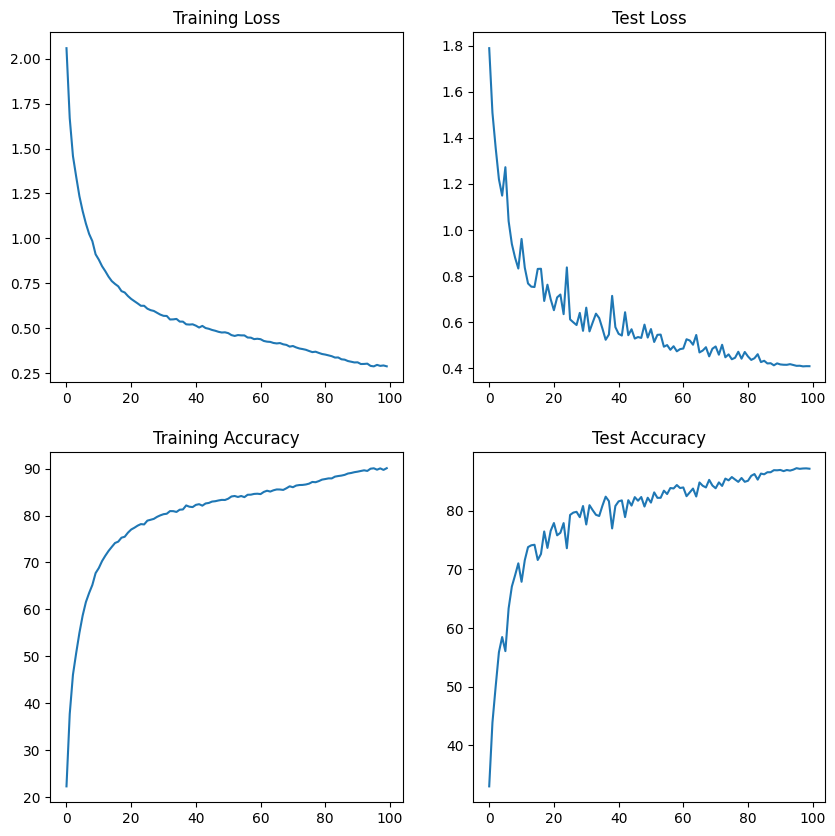

In [18]:
# Print loss and accuracy
from utils import display_loss_and_accuracies

display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

## Visualize Misclassified Images

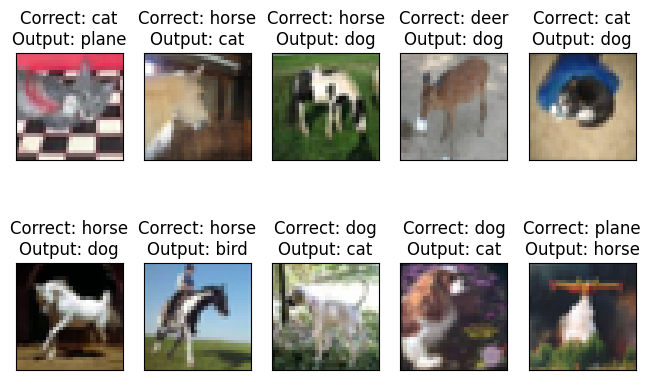

In [19]:
from utils import get_misclassified_data
from utils import display_cifar_misclassified_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.4942/0.2466, -0.4851/0.2428, -0.4504/0.2615],
    std=[1/0.2466, 1/0.2428, 1/0.2615]
)

# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(model, device, test_loader)

# Plot the misclassified data
display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=10)